In [1]:
# 🛠️ Cell 1: Imports & reproducibility
import itertools
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
tf.random.set_seed(42)


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("Training samples:", x_train.shape, "Test samples:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training samples: (50000, 32, 32, 3) Test samples: (10000, 32, 32, 3)


In [3]:
# Model factory function
def build_cnn(num_blocks, use_bn, use_do, activation, dropout_rate=0.25):
    inp = layers.Input(shape=(32, 32, 3))
    x = inp

    for i in range(num_blocks):
        x = layers.Conv2D(32 * (2**i), (3,3), padding="same")(x)
        if use_bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.MaxPooling2D()(x)
        if use_do:
            x = layers.Dropout(dropout_rate)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    if use_do:
        x = layers.Dropout(dropout_rate)(x)

    out = layers.Dense(10, activation="softmax")(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [4]:
#  Hyperparameter grid & early stopping
depth_options      = [2, 3]             # number of Conv+Pool blocks
batchnorm_options  = [False, True]
dropout_options    = [False, True]
activation_options = ["relu", "tanh"]

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    restore_best_weights=True
)


In [5]:
# ▶️ Cell 5: Grid search loop
results = []

for num_blocks, use_bn, use_do, act in itertools.product(
    depth_options, batchnorm_options, dropout_options, activation_options
):
    print(f"\n▶️ Training: blocks={num_blocks}, BN={use_bn}, DO={use_do}, act={act}")
    model = build_cnn(num_blocks, use_bn, use_do, act)

    history = model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=2
    )

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results.append({
        "blocks":     num_blocks,
        "batchnorm":  use_bn,
        "dropout":    use_do,
        "activation": act,
        "test_loss":  loss,
        "test_acc":   acc
    })



▶️ Training: blocks=2, BN=False, DO=False, act=relu
Epoch 1/10
352/352 - 9s - 27ms/step - accuracy: 0.4351 - loss: 1.5809 - val_accuracy: 0.5512 - val_loss: 1.2815
Epoch 2/10
352/352 - 4s - 11ms/step - accuracy: 0.5806 - loss: 1.1909 - val_accuracy: 0.6130 - val_loss: 1.1084
Epoch 3/10
352/352 - 3s - 8ms/step - accuracy: 0.6396 - loss: 1.0356 - val_accuracy: 0.6442 - val_loss: 1.0386
Epoch 4/10
352/352 - 2s - 6ms/step - accuracy: 0.6742 - loss: 0.9394 - val_accuracy: 0.6538 - val_loss: 1.0188
Epoch 5/10
352/352 - 2s - 6ms/step - accuracy: 0.7008 - loss: 0.8676 - val_accuracy: 0.6612 - val_loss: 0.9998
Epoch 6/10
352/352 - 2s - 6ms/step - accuracy: 0.7210 - loss: 0.8073 - val_accuracy: 0.6762 - val_loss: 0.9597
Epoch 7/10
352/352 - 2s - 7ms/step - accuracy: 0.7404 - loss: 0.7551 - val_accuracy: 0.6870 - val_loss: 0.9333
Epoch 8/10
352/352 - 3s - 8ms/step - accuracy: 0.7563 - loss: 0.7080 - val_accuracy: 0.6956 - val_loss: 0.9134
Epoch 9/10
352/352 - 2s - 6ms/step - accuracy: 0.7675 - l

In [6]:
# 📊 Cell 6: Summarize & sort results
df = pd.DataFrame(results)
df = df.sort_values("test_acc", ascending=False).reset_index(drop=True)
df


,blocks,batchnorm,dropout,activation,test_loss,test_acc
0,3,True,True,relu,0.745205,0.7440
1,3,False,True,relu,0.746846,0.7397
2,3,False,True,tanh,0.825593,0.7189
3,2,True,True,relu,0.821704,0.7151
4,3,False,False,relu,0.878445,0.7139
5,3,True,True,tanh,0.837698,0.7138
6,3,False,False,tanh,0.957754,0.7057
7,2,False,True,relu,0.874557,0.6942
8,2,False,False,tanh,0.947594,0.6856
9,2,True,True,tanh,0.906100,0.6841


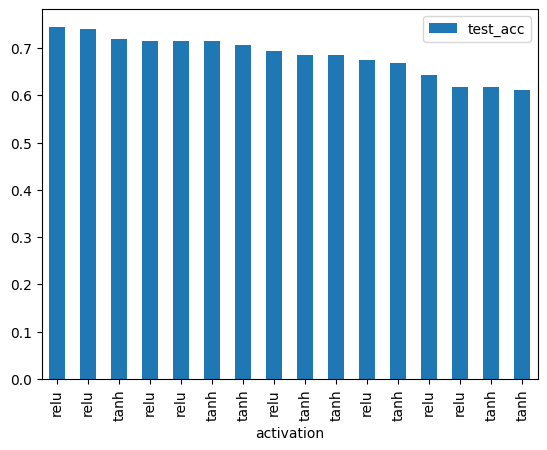

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.plot(kind="bar", x="activation", y="test_acc", ax=ax)
plt.show()
